# Panic Project (DHLAB) - Data Analysis

author:  `@cyshin971`  

date:    `2025-06-XX`  

version: `1.1`

> version `1.1`: preprocessing separated to `data_preprocessing.ipynb` (version `1.0`)

# 📚 | Import Libraries 

In [1]:
import config as cfg
import logging

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from library.pandas_utils import move_column, remove_columns, aggregate_by_column, create_empty_df, read_csv
from library.text_utils import save_as_csv
from library.json_utils import save_dict_to_file, load_dict_from_file
from library.path_utils import get_file_path

# 📁 | Path Variables 

In [2]:
DATA_PATH = "../_data"
TMP_PATH = "./cys/_tmp"
OUTPUT_PATH = "./cys/_output"

# ⚒️ | Preprocessed Data

## Load Preprocessed Data

In [3]:
try:
	features_dict = load_dict_from_file(OUTPUT_PATH, 'panic_features_dict')
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {get_file_path(OUTPUT_PATH, 'panic_features_dict')}. Please run data_analysis.ipynb first.")
print(f"Loaded features dict with {len(features_dict)} keys:")
scraped_data_filename = None
for k, v in features_dict.items():
    if k == 'scraped_data_filename':
        print(f"  {k}: {v}.csv")
        scraped_data_filename = v
    else:
        print(f"  {k}: {len(v)}")

if scraped_data_filename is None:
	raise ValueError("scraped_data_filename not found in features_dict")

pre_data = read_csv(get_file_path(OUTPUT_PATH, f'panic_pre_data({scraped_data_filename}).csv'))
display(pre_data.head(5))
metadata = read_csv(get_file_path(OUTPUT_PATH, f'panic_metadata({scraped_data_filename}).csv'))
display(metadata.head(5))
demography_data = read_csv(get_file_path(OUTPUT_PATH, f'panic_demography_data({scraped_data_filename}).csv'))
display(demography_data.head(5))

DEBUG - (json_utils.py) load_dict_from_file: Dictionary loaded successfully from C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\panic_features_dict.json


Loaded features dict with 10 keys:
  scraped_data_filename: final_result_diary_20250616.csv
  demography: 8
  dailylog: 12
  lifelog: 37
  questionnaire: 17
  diary: 2
  excluded: 9
  id: 4
  label: 3
  metadata: 9


,entry_id,dataset,ID,date,PHQ_9,STAI_X2,CSM,CTQ_1,CTQ_2,CTQ_3,...,SLT1,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,severity,dbp,panic_label
0,PXPN_10006_2024-11-04,PXPN,PXPN_10006,2024-11-04,0.0,32.0,31.0,11.0,13.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,PXPN_10006_2024-11-05,PXPN,PXPN_10006,2024-11-05,0.0,32.0,31.0,11.0,13.0,17.0,...,0.0,4.47,3.62,4.67,0.65,1.85,15.26,NaN,NaN,0
2,PXPN_10006_2024-11-06,PXPN,PXPN_10006,2024-11-06,0.0,32.0,31.0,11.0,13.0,17.0,...,0.0,0.00,0.20,4.07,1.43,1.68,7.38,NaN,1.0,0
3,PXPN_10006_2024-11-07,PXPN,PXPN_10006,2024-11-07,0.0,32.0,31.0,11.0,13.0,17.0,...,0.0,0.00,0.14,5.08,0.00,0.97,6.19,1.0,0.0,1
4,PXPN_10006_2024-11-08,PXPN,PXPN_10006,2024-11-08,0.0,32.0,31.0,11.0,13.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


,entry_id,ID,date,dataset,coffee,smoking,total_sleep,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,n_prior_data,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
0,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,NaN,NaN,NaN,0,1,1,2,NaN,2,0,1,1,NaN,0,NaN
1,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,NaN,NaN,NaN,0,1,1,2,NaN,1,0,0,1,NaN,0,NaN
2,SYM2-1-96_2021-08-02,SYM2-1-96,2021-08-02,SYM2,NaN,NaN,NaN,0,1,1,2,NaN,0,0,0,0,NaN,0,NaN
3,SYM2-1-96_2021-07-30,SYM2-1-96,2021-07-30,SYM2,NaN,NaN,NaN,0,1,1,2,NaN,3,1,1,1,NaN,0,NaN
4,SYM2-1-96_2021-07-29,SYM2-1-96,2021-07-29,SYM2,NaN,NaN,NaN,0,1,1,2,NaN,2,0,1,1,NaN,0,NaN


,ID,gender,age,marriage,job,smkHx,drinkHx,suicideHx,suicide_need
0,PXPN_10006,0,32.0,0.0,1.0,1.0,1.0,0.0,0.0
1,PXPN_10007,1,38.0,1.0,1.0,0.0,0.0,0.0,0.0
2,PXPN_10008,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
3,PXPN_10009,1,28.0,0.0,0.0,1.0,0.0,1.0,0.0
4,PXPN_10010,1,21.0,0.0,0.0,1.0,1.0,0.0,0.0


# 🔍 | Data Analysis

In [4]:
from library.matplotlib_utils import plot_histogram_of_counts

## 🤢 | Patient-level Analysis

**Description**
- `n_entries`: Number of entries per patient
- `n_valid_3_entries`: Number of valid (3 prior consecutive days of data) entries per patient
- `n_valid_2_entries`: Number of valid (2 prior consecutive days of data) entries per patient
- `n_valid_1_entries`: Number of valid (1 prior consecutive days of data) entries per patient
- `n_panic`: Number of panic events per patient
- `max_severity`: Maximum panic severity experienced by patient
- `min_severity`: Minimum panic severity experienced by patient
- `mean_severity`: Average panic severity experienced by patient
- `n_dailylog`: Number of daily log entries per patient
- `n_lifelog`: Number of life log entries per patient
- `n_questionnaire`: Number of questionnaire entries per patient
- `sum_dtype`: Number of data (by group) per patient
- `mean_dtype`: Average number of data types per entry per patient

In [5]:
agg_matrix = [
	('n_entries', 'entry_id', 'count'),
	('n_valid_3_entries', 'valid_entry_3', 'sum'),
	('n_valid_2_entries', 'valid_entry_2', 'sum'),
	('n_valid_1_entries', 'valid_entry_1', 'sum'),
	('n_panic', 'panic_label', 'sum'),
    ('max_severity', 'severity', 'max'),
	('min_severity', 'severity', 'min'),
	('mean_severity', 'severity', 'mean'),
	('n_dailylog', 'dailylog_data', 'sum'),
	('n_lifelog', 'lifelog_data', 'sum'),
	('n_questionnaire', 'questionnaire_data', 'sum'),
	('sum_dtype', 'dtype_n', 'sum'),
	('mean_dtype', 'dtype_n', 'mean'),
	('coffee_mean', 'coffee', 'mean'),
    ('coffee_n', 'coffee', 'count'),
    ('smoking_mean', 'smoking', 'mean'),
    ('total_sleep_mean', 'total_sleep', 'mean'),
]
patient_analysis_data = create_empty_df()
patient_analysis_data = aggregate_by_column(metadata, 'ID', agg_matrix)

display(patient_analysis_data.head(5))
save_as_csv(patient_analysis_data, OUTPUT_PATH, f"panic_patient_analysis({scraped_data_filename})")

,ID,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype,coffee_mean,coffee_n,smoking_mean,total_sleep_mean
0,PXPN_10006,29,18,21,25,3,2.0,1.0,1.33,22,29,29,80,2.76,1.00,4,NaN,6.95
1,PXPN_10007,29,16,20,24,4,2.0,1.0,1.25,20,29,29,78,2.69,1.53,17,NaN,NaN
2,PXPN_10008,29,18,21,25,3,2.0,1.0,1.67,20,29,29,78,2.69,1.00,1,NaN,NaN
3,PXPN_10009,29,18,20,23,5,4.0,1.0,2.60,28,28,29,85,2.93,1.17,12,5.00,NaN
4,PXPN_10010,29,26,27,28,0,NaN,NaN,NaN,23,28,29,80,2.76,1.37,19,8.57,NaN


DEBUG - (text_utils.py) save_as_csv: Saved panic_patient_analysis(final_result_diary_20250616).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/panic_patient_analysis(final_result_diary_20250616).csv')

# Fill Null Values

## Daily Log

- coffee: Fill with average coffee cups per patient for patients with entries, else fill with 0
- smoking: Fill with average times of smoking per patient with history of smoking, else fill with 0
- total_sleep: Fill with average sleep time per patient. if no sleep data exists fill with 8 Hour Sleep

### Coffee

In [6]:
# coffee_test_null = patient_analysis_data['coffee_mean'].isnull()

# print(f"Coffee data is null for {coffee_test_null.sum()} patients ({coffee_test_null.mean() * 100:.2f}%)")
# coffee_test_not_null = ~coffee_test_null
# print(f"Coffee data is not null for {coffee_test_not_null.sum()} patients ({coffee_test_not_null.mean() * 100:.2f}%)")
# plot_histogram_of_counts(patient_analysis_data['coffee_n'], title='Number of coffee entries per patient',
#                          xlabel='Coffee entries', ylabel='Number of patients', bins_step=20)

In [7]:
pre_data_filled_coffee = create_empty_df()
pre_data_filled_coffee = pre_data.copy()

# make a dictionary of ID and coffee_mean from patient_analysis_data
coffee_mean_dict = patient_analysis_data.set_index('ID')['coffee_mean'].to_dict()
pre_data_filled_coffee.loc[pre_data_filled_coffee['coffee'].isnull(), 'coffee'] = pre_data_filled_coffee.loc[pre_data_filled_coffee['coffee'].isnull(), 'ID'].map(coffee_mean_dict)
pre_data_filled_coffee['coffee'] = pre_data_filled_coffee['coffee'].fillna(0.0)

# save_as_csv(pre_data_filled_coffee, TMP_PATH, f"panic_pre_data_filled_coffee({scraped_data_filename})")

### Smoking

In [8]:
pre_data_filled_smoking = create_empty_df()
pre_data_filled_smoking = pre_data_filled_coffee.copy()

smoking_mean_dict = patient_analysis_data.set_index('ID')['smoking_mean'].to_dict()
smokingHx_dict = demography_data.set_index('ID')['smkHx'].to_dict()
# get rid of keys in smokingHx_dict that are not in smoking_mean_dict
smokingHx_dict = {k: v for k, v in smokingHx_dict.items() if k in smoking_mean_dict}
# use smokingHx_dict to replace the smoking_mean_dict values such that if the smokingHx is 0, the smoking_mean_dict value is set to 0 else keep the smoking_mean_dict value
smoking_mean_dict = {k: (0.0 if v == 0 else smoking_mean_dict[k]) for k, v in smokingHx_dict.items()}
# fill the smoking column in pre_data_filled_smoking with the smoking_mean_dict values
pre_data_filled_smoking.loc[pre_data_filled_smoking['smoking'].isnull(), 'smoking'] = pre_data_filled_smoking.loc[pre_data_filled_smoking['smoking'].isnull(), 'ID'].map(smoking_mean_dict)

pre_data_filled_smoking['smoking'] = pre_data_filled_smoking['smoking'].fillna(0.0)
# save_as_csv(pre_data_filled_smoking, TMP_PATH, f"panic_pre_data_filled_smoking({scraped_data_filename})")

### Total Sleep

In [9]:
pre_data_filled_totsleep = create_empty_df()
pre_data_filled_totsleep = pre_data_filled_smoking.copy()

totsleep_mean_dict = patient_analysis_data.set_index('ID')['total_sleep_mean'].to_dict()
pre_data_filled_totsleep.loc[pre_data_filled_totsleep['total_sleep'].isnull(), 'total_sleep'] = pre_data_filled_totsleep.loc[pre_data_filled_totsleep['total_sleep'].isnull(), 'ID'].map(totsleep_mean_dict)
pre_data_filled_totsleep['total_sleep'] = pre_data_filled_totsleep['total_sleep'].fillna(8.0)

# save_as_csv(pre_data_filled_totsleep, TMP_PATH, f"panic_pre_data_filled_totsleep({scraped_data_filename})")


## 💾 | Save Filled Data

In [10]:
pre_data_filled = create_empty_df()
pre_data_filled = pre_data_filled_totsleep.copy()

save_as_csv(pre_data_filled, OUTPUT_PATH, f"panic_pre_data_filled({scraped_data_filename})")

DEBUG - (text_utils.py) save_as_csv: Saved panic_pre_data_filled(final_result_diary_20250616).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/panic_pre_data_filled(final_result_diary_20250616).csv')

# 📒 | Reports

In [11]:
from library.matplotlib_utils import plot_histogram_of_counts

## 🗒️ | Entry-level Analysis

### Data Groups

In [12]:
data_pre_entry_ids = pre_data['entry_id'].unique()
print(f"Total number of daily log entries: {metadata[metadata['dailylog_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['dailylog_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")
print(f"Total number of life log entries: {metadata[metadata['lifelog_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['lifelog_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")
print(f"Total number of questionnaire entries: {metadata[metadata['questionnaire_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['questionnaire_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")

Total number of daily log entries: 14854 / 24105 (61.62%)
Total number of life log entries: 19299 / 24105 (80.06%)
Total number of questionnaire entries: 20045 / 24105 (83.16%)


In [13]:
test = metadata[metadata['dailylog_data'] == 1]

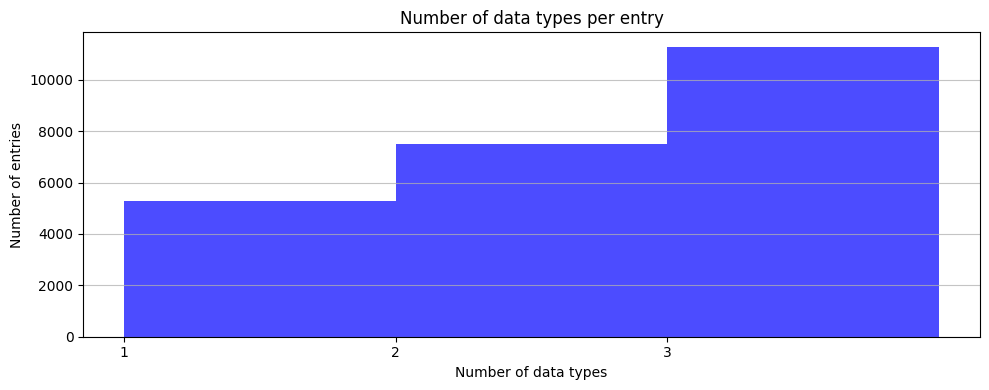

Number of entries with 1 data type: 5299 (21.98%)
Number of entries with 2 data types: 7519 (31.19%)
Number of entries with 3 data types: 11287 (46.82%)


In [14]:
plot_histogram_of_counts(metadata['dtype_n'], title='Number of data types per entry', xlabel='Number of data types', ylabel='Number of entries', zero_start=False, bins_step=1)
print(f"Number of entries with 1 data type: {metadata[metadata['dtype_n'] == 1].shape[0]} ({metadata[metadata['dtype_n'] == 1].shape[0] / metadata.shape[0] * 100:.2f}%)")
print(f"Number of entries with 2 data types: {metadata[metadata['dtype_n'] == 2].shape[0]} ({metadata[metadata['dtype_n'] == 2].shape[0] / metadata.shape[0] * 100:.2f}%)")
print(f"Number of entries with 3 data types: {metadata[metadata['dtype_n'] == 3].shape[0]} ({metadata[metadata['dtype_n'] == 3].shape[0] / metadata.shape[0] * 100:.2f}%)")

### Valid Entries

In [15]:
print(f"Total number of valid entries (3 days): {metadata['valid_entry_3'].sum()} ({metadata['valid_entry_3'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (2 days): {metadata['valid_entry_2'].sum()} ({metadata['valid_entry_2'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (1 day): {metadata['valid_entry_1'].sum()} ({metadata['valid_entry_1'].mean() * 100:.2f}%)")

Total number of valid entries (3 days): 20786 (86.23%)
Total number of valid entries (2 days): 21462 (89.04%)
Total number of valid entries (1 day): 22441 (93.10%)


In [16]:
panic_n = pre_data[pre_data['dbp'] == 0].shape[0]
print(f"Total number of panic events (dbp=0): {panic_n}")
valid_panic_events_3 = metadata[(metadata['valid_entry_3'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 3 days): {valid_panic_events_3} ({valid_panic_events_3 / panic_n * 100:.2f}%)")
valid_panic_events_2 = metadata[(metadata['valid_entry_2'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 2 days): {valid_panic_events_2} ({valid_panic_events_2 / panic_n * 100:.2f}%)")
valid_panic_events_1 = metadata[(metadata['valid_entry_1'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (n_prior_data >= 1 day): {valid_panic_events_1} ({valid_panic_events_1 / panic_n * 100:.2f}%)")

Total number of panic events (dbp=0): 802
Total number of valid panic events (n_prior_data >= 3 days): 198 (24.69%)
Total number of valid panic events (n_prior_data >= 2 days): 216 (26.93%)
Total number of valid panic events (n_prior_data >= 1 day): 264 (32.92%)


## 🤢 | Patient-level Analysis

In [17]:
pre_data_ids = pre_data['ID'].unique()

### Patient-level Valid Entries

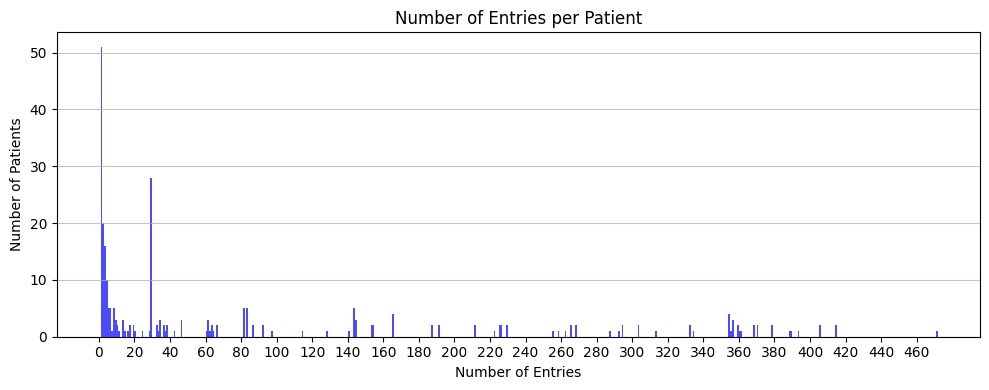

Number of valid patients (1 days): 206 / 274
68 patients do not have valid entries (i.e., no data for at least 1 days before panic event)


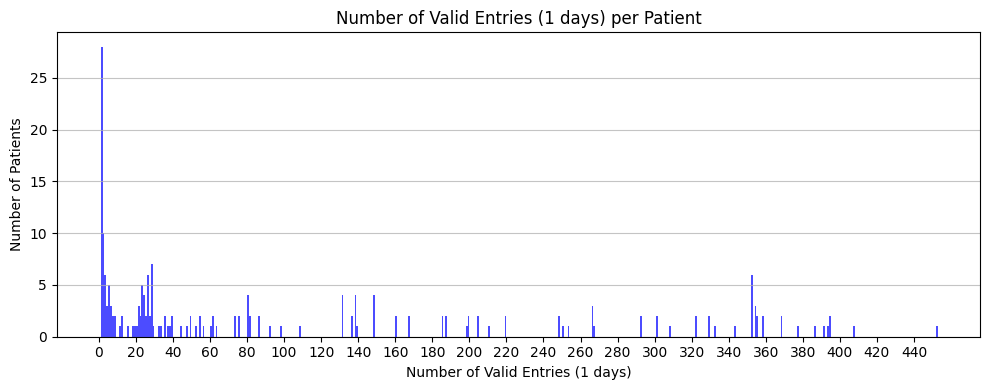

Number of valid patients (2 days): 173 / 274
101 patients do not have valid entries (i.e., no data for at least 2 days before panic event)


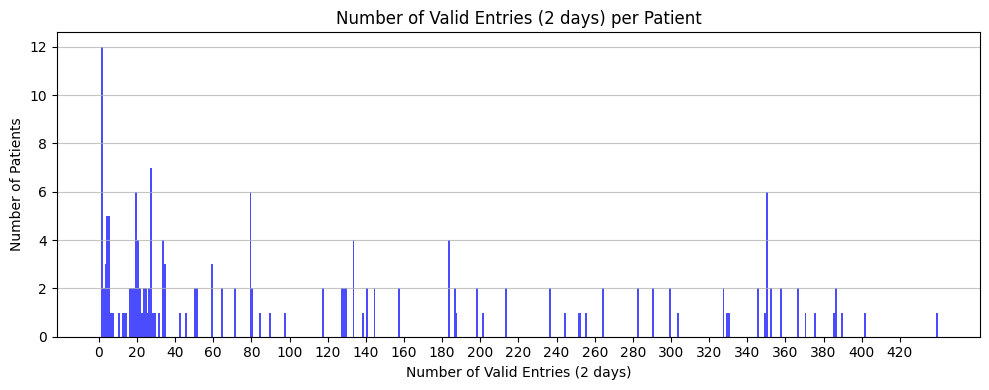

Number of valid patients (3 days): 161 / 274
113 patients do not have valid entries (i.e., no data for at least 3 days before panic event)


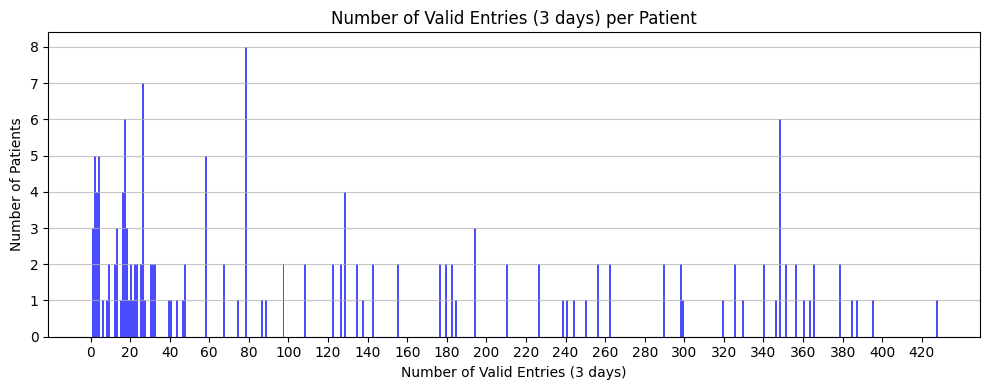

In [18]:
plot_histogram_of_counts(patient_analysis_data['n_entries'], title='Number of Entries per Patient',
                         xlabel='Number of Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_1_entries'] > 0]
n_valid_patients_1 = valid_patients.shape[0]
print(f"Number of valid patients (1 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 1 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_1_entries'], title='Number of Valid Entries (1 days) per Patient',
                         xlabel='Number of Valid Entries (1 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_2_entries'] > 0]
n_valid_patients_2 = valid_patients.shape[0]
print(f"Number of valid patients (2 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 2 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_2_entries'], title='Number of Valid Entries (2 days) per Patient',
                         xlabel='Number of Valid Entries (2 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_3_entries'] > 0]
n_valid_patients_3 = valid_patients.shape[0]
print(f"Number of valid patients (3 days): {valid_patients.shape[0]} / {len(pre_data_ids)}")
print(f"{len(pre_data_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 3 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_3_entries'], title='Number of Valid Entries (3 days) per Patient',
                         xlabel='Number of Valid Entries (3 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
del valid_patients

### Patient-level Panic Analysis

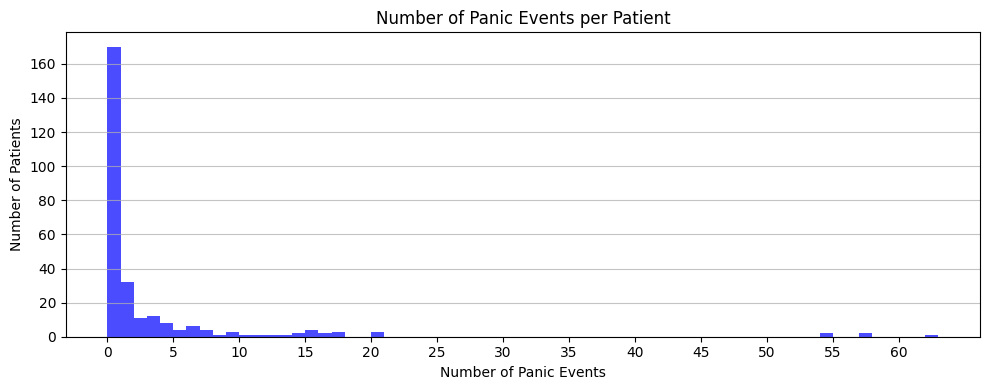

Number of patients with zero panic events: 170 / 274


In [19]:
plot_histogram_of_counts(patient_analysis_data['n_panic'], title='Number of Panic Events per Patient', xlabel='Number of Panic Events', ylabel='Number of Patients', bins_step=5)
print(f"Number of patients with zero panic events: {patient_analysis_data[patient_analysis_data['n_panic'] == 0].shape[0]} / {len(pre_data_ids)}")

In [20]:
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_3_entries'] > 0)]
print(f"Number of patients with valid panic events (3 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_3}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_2_entries'] > 0)]
print(f"Number of patients with valid panic events (2 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_2}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_1_entries'] > 0)]
print(f"Number of patients with valid panic events (1 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_1}")
del valid_panic_events_patients

Number of patients with valid panic events (3 days): 81 / 161
Number of patients with valid panic events (2 days): 86 / 173
Number of patients with valid panic events (1 days): 93 / 206


### Patient-level Data Group Analysis

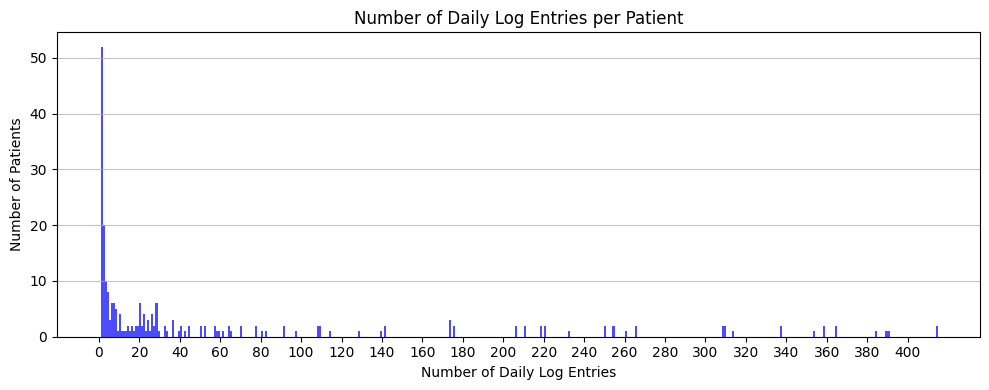

Number of patients with no daily log entries: 36 / 274


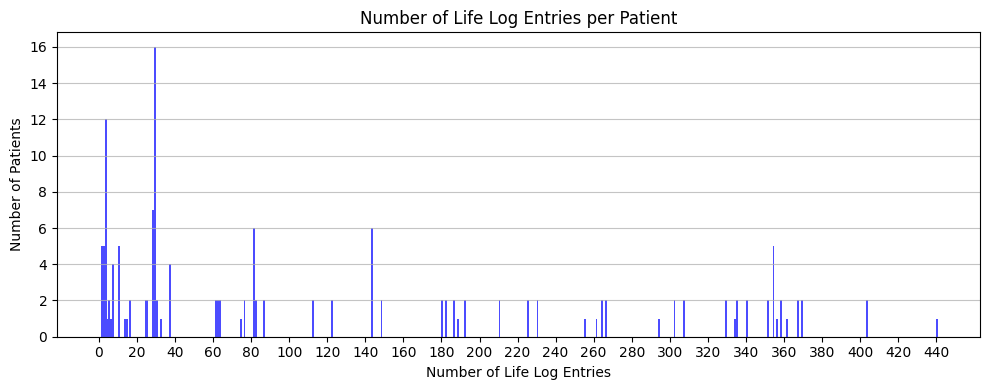

Number of patients with no life log entries: 119 / 274


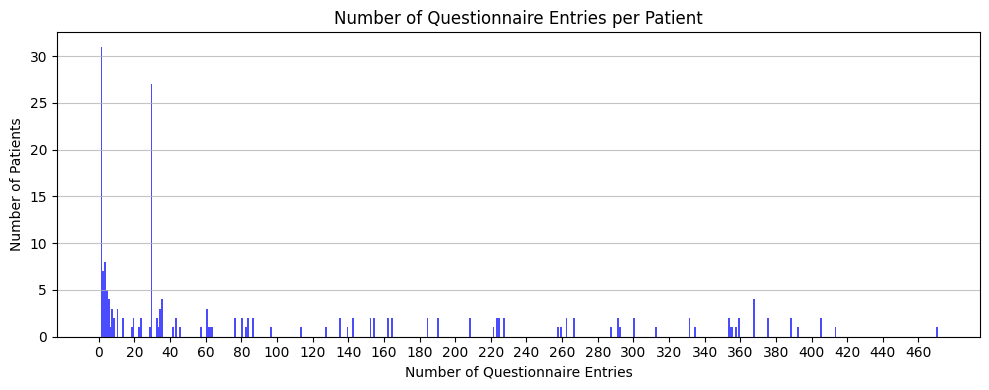

Number of patients with no questionnaire entries: 79 / 274


In [21]:
plot_histogram_of_counts(patient_analysis_data['n_dailylog'], title='Number of Daily Log Entries per Patient',
						 xlabel='Number of Daily Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no daily log entries: {patient_analysis_data[patient_analysis_data['n_dailylog'] == 0].shape[0]} / {len(pre_data_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_lifelog'], title='Number of Life Log Entries per Patient',
						 xlabel='Number of Life Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no life log entries: {patient_analysis_data[patient_analysis_data['n_lifelog'] == 0].shape[0]} / {len(pre_data_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_questionnaire'], title='Number of Questionnaire Entries per Patient',
						 xlabel='Number of Questionnaire Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no questionnaire entries: {patient_analysis_data[patient_analysis_data['n_questionnaire'] == 0].shape[0]} / {len(pre_data_ids)}")